## Protocol 2: Evaluating the Temporal Performance of Visual Stimulus Presentation

This protocol aims to verify the **temporal accuracy and stability** of the actual appearance of a visual stimulus on a screen.

### Requirements

**Hardware:**
- A digital oscilloscope or acquisition device (e.g., Analog Discovery 3)
- **Two computer monitors**
- A **photodiode** with its power supply circuit

**Software:**
- Acquisition and measurement software (e.g., **Digilent Waveforms**, version `3.24.2`)
- **Python 3** with required libraries (e.g., `pyserial`, `expyriment`, `psychopy2`)

---

### Step 1: Stimulus Generation

1. **Use two monitors**: one for the recording window (Waveforms), and one for visual stimulus presentation.

2. **Prepare your `.py` script** that displays the visual stimuli, taking the desired period as an argument. MODIFY CODE IF NEEDED.

> **Python script (.py) for stimulus presentation:**
> ```python
> from expyriment import design, control, stimuli, misc
>
> # --- Setup Expyriment ---
> exp = design.Experiment(name="Stimuli_Only")
> control.set_develop_mode(True)
> control.initialize(exp)
>
> PERIOD = 250  # Intervalle total en ms
> SQUARE_DURATION = 100  # ms
>
> square = stimuli.Rectangle((400, 400), position=(0, 0))
> blank = stimuli.BlankScreen()
> square.preload()
> blank.preload()
>
> exp.add_data_variable_names(['trial', 'stimulus_time'])
>
> control.start(skip_ready_screen=True)
> clock2 = misc.Clock()
> i = 1
>
> while i <= 10000:
>     while (clock2.time < i * PERIOD - 3):
>         pass
>
>     stim_time = clock2.time + square.present(update=True)
>
>     while (clock2.time - stim_time < SQUARE_DURATION - 3):
>         pass
>     blank.present(update=True)
>
>     exp.data.add([i, stim_time])
>     i += 1
>     exp.keyboard.process_control_keys()
>
> control.end()
> ```

3. **Run the script** from your terminal.  
    > ![Screenshot from 2025-07-09 17-03-35.png](<attachment:Screenshot from 2025-07-09 17-03-35.png>)

4. A window displaying the stimuli should now be visible. **Move this window to the secondary screen**.

---

### Step 2: Signal Acquisition

1. **Connect the oscilloscope probes:**
   - GND probe to the photodiode’s GND
   - Measurement probe to the photodiode's output (Vout)

2. **Place the photodiode** at the location where the stimuli appear on the screen.

3. **Launch the Waveforms software** (or equivalent) and click **`Scope`**  
    > ![Screenshot from 2025-07-09 10-17-35.png](<attachment:Screenshot from 2025-07-09 10-17-35.png>)
    > ![Screenshot from 2025-07-09 10-17-57.png](<attachment:Screenshot from 2025-07-09 10-17-57.png>)

4. Click **`Run`** to begin acquisition. You should see a signal varying with the light intensity hitting the photodiode, on the channel corresponding to your setup.  
    > ![Screenshot from 2025-07-09 14-23-50.png](<attachment:Screenshot from 2025-07-09 14-23-50.png>)

5. You can visually inspect the signal (period, amplitude, duty cycle) by **adjusting the axis scales**.  
    > ![Screenshot from 2025-07-09 14-24-17.png](<attachment:Screenshot from 2025-07-09 14-24-17.png>)

6. **Adjust the scales** and start acquisition again by clicking **`Run`**.

---

### Step 3: Signal Recording

1. Click the **`Record`** button.  
    > ![Screenshot from 2025-07-09 14-24-28.png](<attachment:Screenshot from 2025-07-09 14-24-28.png>)

2. Set the recording parameters:
   - **File format:** `.csv`
   - **Sampling rate:** `10 kHz`
   - **Recording duration:** `20 s`
   - **File path and name**  
    > ![Screenshot from 2025-07-09 14-27-55.png](<attachment:Screenshot from 2025-07-09 14-27-55.png>)

3. Start recording. You will obtain a `.csv` file containing the measured signal.

---

### Step 4: Signal Analysis

1. **Prepare the Python analysis script**. It should allow:
   - Setting a detection threshold
   - Defining a minimum interval between peaks
   - Computing min, max, and mean intervals
   - Generating a histogram of interval distribution
   - Counting the number of peaks and intervals

> **Python script (.py) for analyzing the photodiode signal:**
>
> ```python
> import numpy as np
> import matplotlib
> matplotlib.use('Agg')  # Backend non interactif
> import matplotlib.pyplot as plt
> from scipy.io import wavfile
> from scipy.signal import find_peaks
> import os
>
> # --- Paramètres ---
> NOM_FICHIER_WAV = 'expy_stimuli_only_pc_gaming_250ms.wav'  # Nom du fichier WAV à analyser
> DISTANCE_MIN_MS = 100.0                       # Intervalle minimal entre pics
>
> def analyser_et_sauvegarder_graphique(nom_fichier):
>     """
>     Analyse un signal photodiode au format WAV :
>     - détection des pics
>     - calcul des intervalles
>     - histogramme des intervalles
>     - tracé du signal avec pics
>     """
>     try:
>         sampling_rate, data = wavfile.read(nom_fichier)
>         print(f"\n--- Analyse du fichier : {nom_fichier} ---")
>         print(f"Taux d'échantillonnage : {sampling_rate} Hz")
>
>         if data.ndim > 1:
>             data = data[:, 0]
>
>         signal_abs = np.abs(data)
>         seuil = 0.8 * np.max(signal_abs)
>         print(f"Seuil de détection (80% amplitude max) : {int(seuil)}")
>
>         distance_min_samples = int(DISTANCE_MIN_MS * sampling_rate / 1000)
>
>         indices_pics, _ = find_peaks(signal_abs, height=seuil, distance=distance_min_samples)
>         intervalles_en_samples = np.diff(indices_pics)
>         intervalles_en_ms = (intervalles_en_samples / sampling_rate) * 1000
>
>         print(f"\nNombre de pics détectés : {len(indices_pics)}")
>         print(f"Nombre d'intervalles : {len(intervalles_en_ms)}")
>
>         if len(intervalles_en_ms) > 0:
>             moyenne = np.mean(intervalles_en_ms)
>             print(f"Intervalle moyen : {moyenne:.2f} ms")
>             print(f"Min : {np.min(intervalles_en_ms):.2f} ms")
>             print(f"Max : {np.max(intervalles_en_ms):.2f} ms")
>
>             # --- Histogramme des intervalles ---
>             plt.figure(figsize=(12, 6))
>             plt.hist(intervalles_en_ms, bins=50, edgecolor='black', alpha=0.75)
>             plt.axvline(moyenne, color='red', linestyle='--', linewidth=2, label=f'Moyenne = {moyenne:.2f} ms')
>             plt.title(f"Distribution des intervalles — {os.path.basename(nom_fichier)}", fontsize=14)
>             plt.xlabel("Durée de l'intervalle (ms)")
>             plt.ylabel("Nombre d'intervalles")
>             plt.legend()
>             plt.grid(True, linestyle='--', alpha=0.6)
>
>             output_dir = 'figures'
>             os.makedirs(output_dir, exist_ok=True)
>             base_name = os.path.splitext(os.path.basename(nom_fichier))[0]
>             save_hist_path = os.path.join(output_dir, f'distribution_intervalles_{base_name}.png')
>             plt.savefig(save_hist_path, dpi=300, bbox_inches='tight')
>             plt.close()
>             print(f"\nHistogramme sauvegardé : {save_hist_path}")
>
>             # --- Tracé du signal avec pics ---
>             plt.figure(figsize=(15, 5))
>             plt.plot(data, label='Signal')
>             plt.plot(indices_pics, data[indices_pics], 'rx', label='Pics détectés')
>             plt.title(f"Signal et pics détectés — {base_name}")
>             plt.xlabel("Échantillons")
> ```

2. **Run the script.**

3. The script will output the signal characteristics and the latency intervals in the terminal, and save a histogram in the designated path.  
    > ![Screenshot from 2025-06-23 15-07-15.png](<attachment:Screenshot from 2025-06-23 15-07-15.png>)
    > 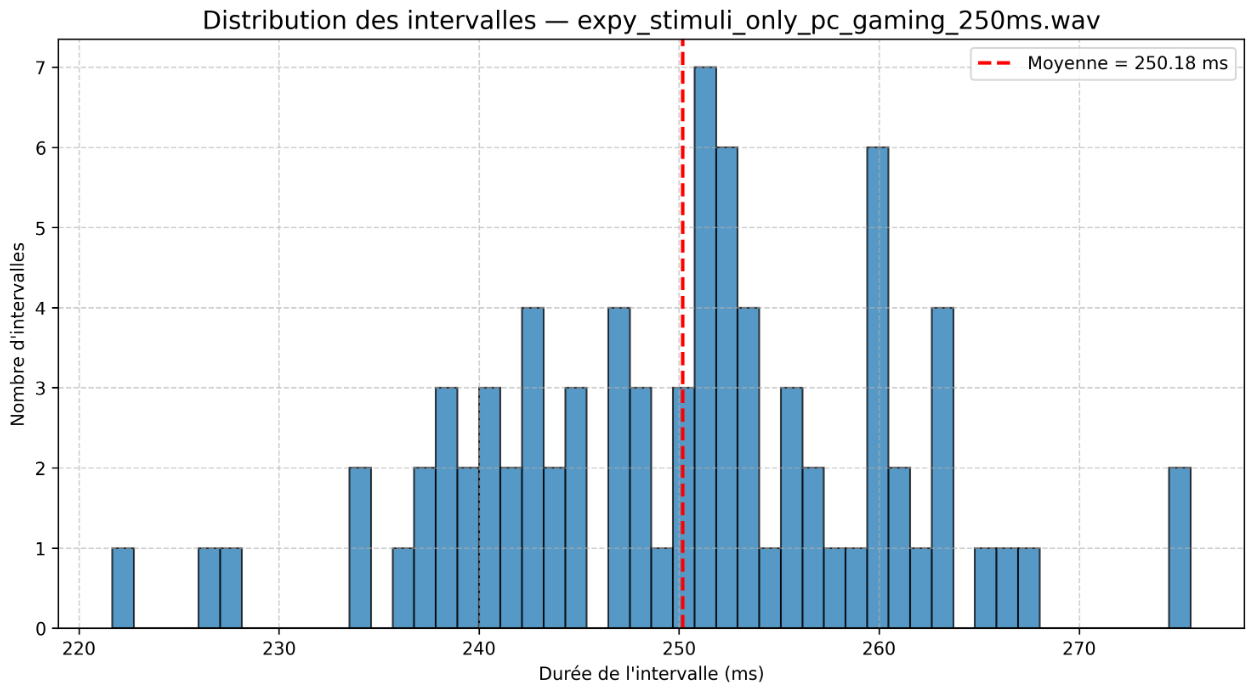


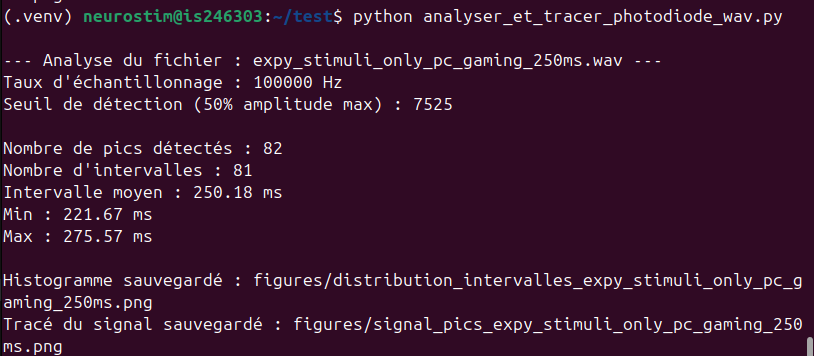
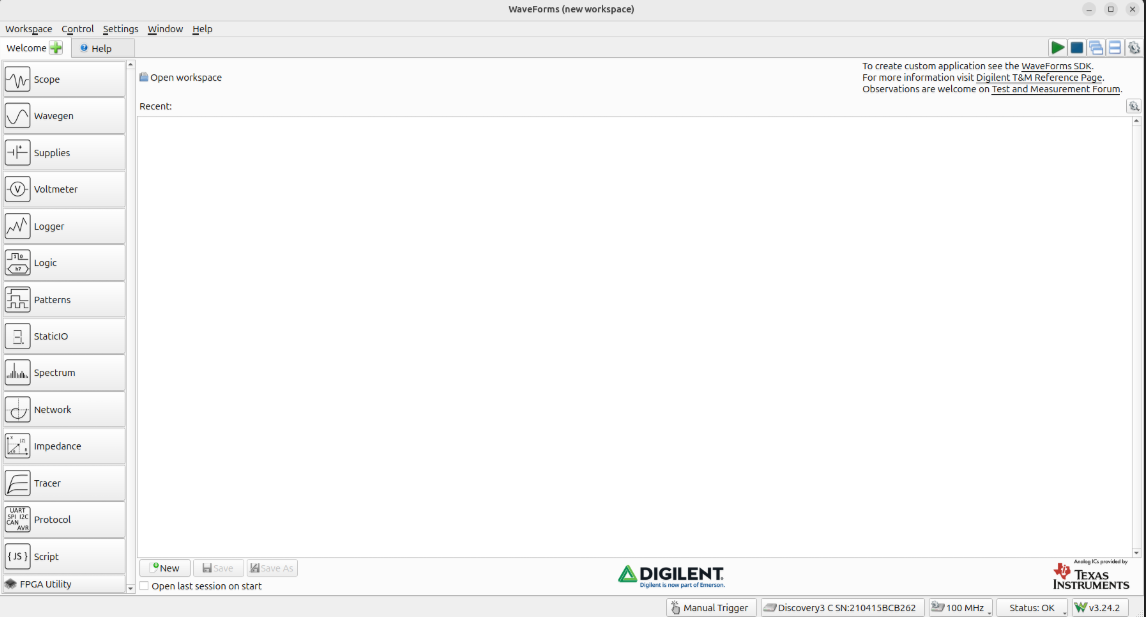
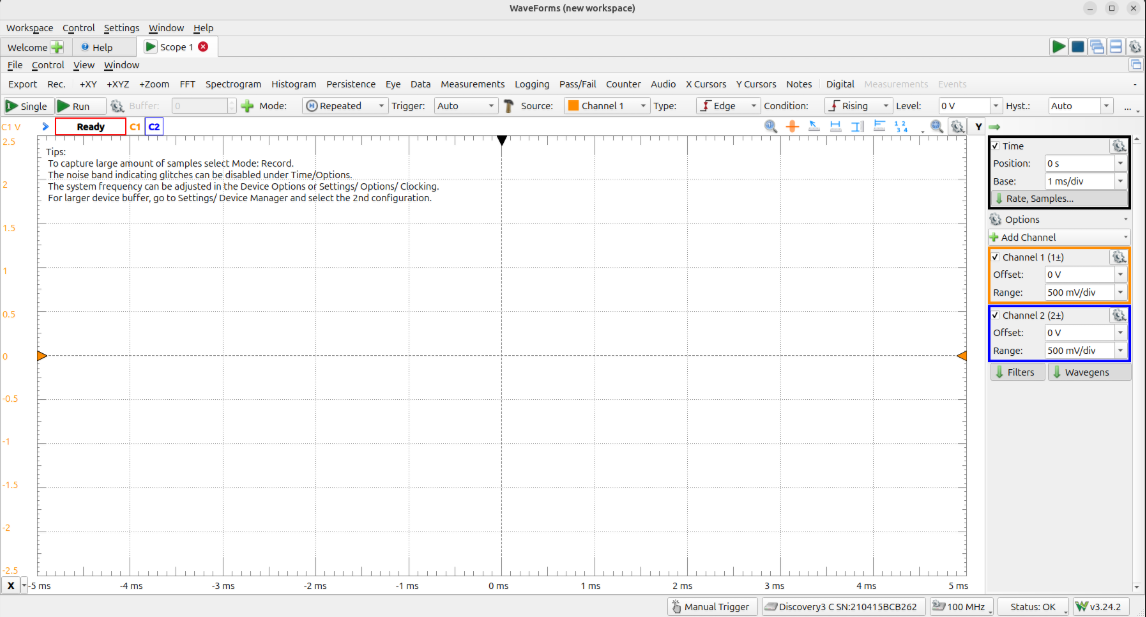
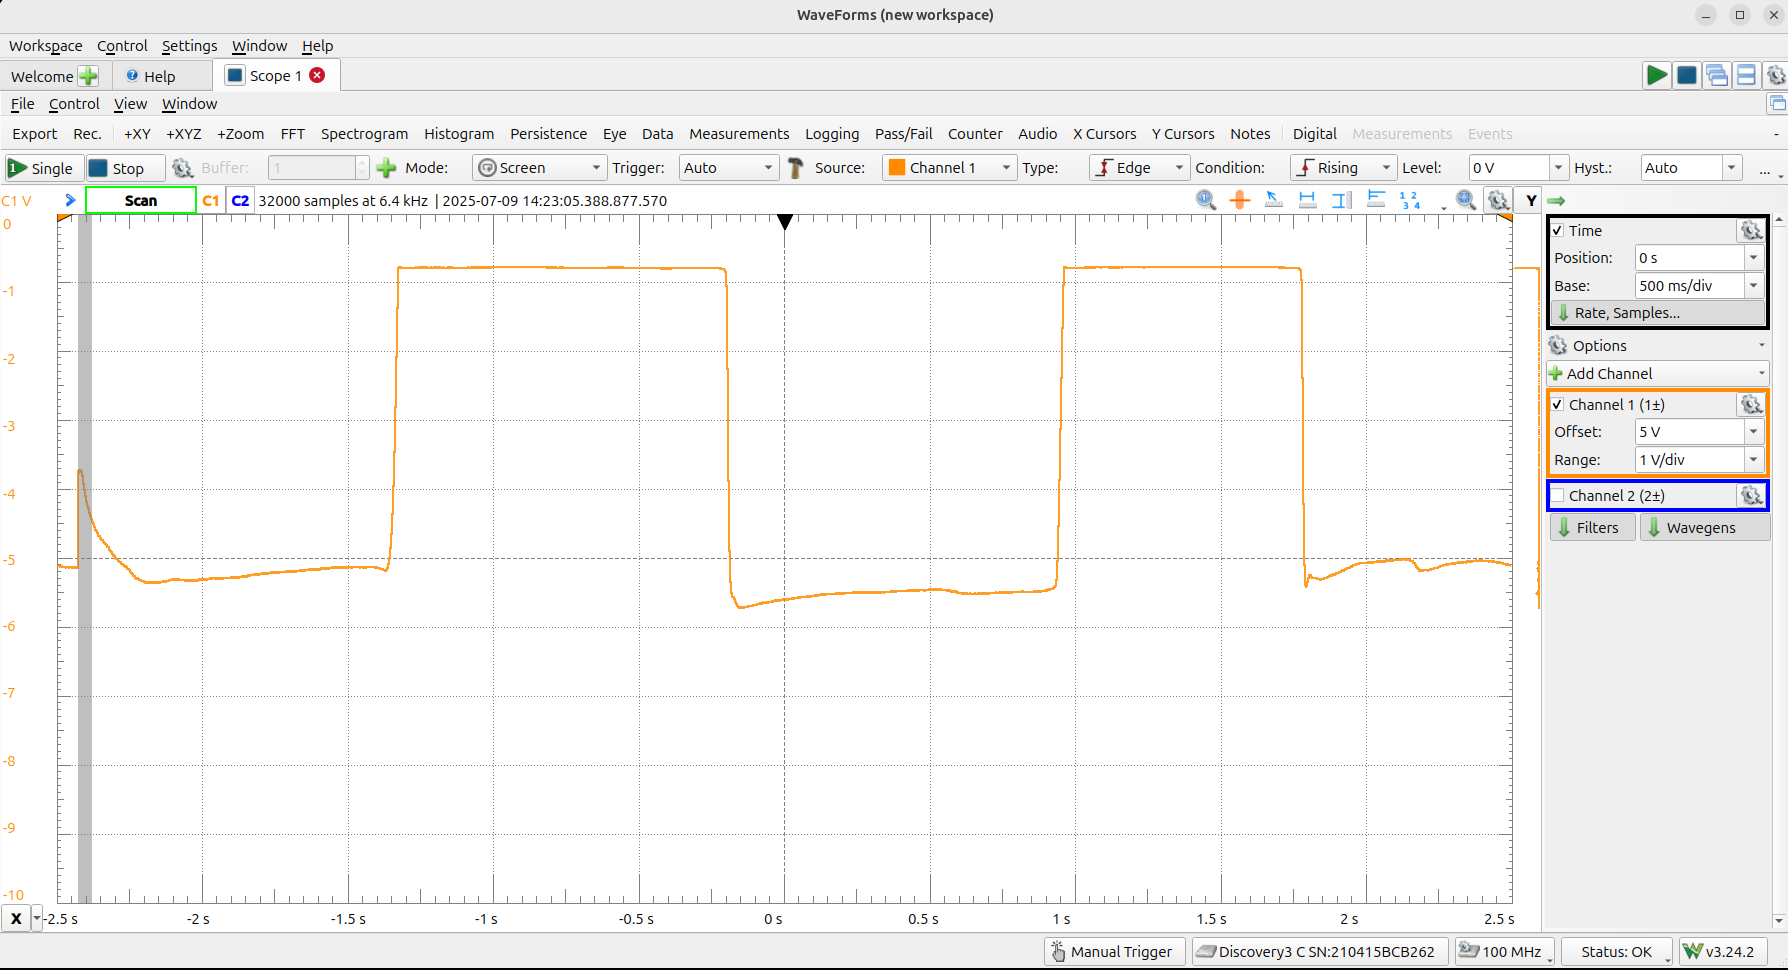
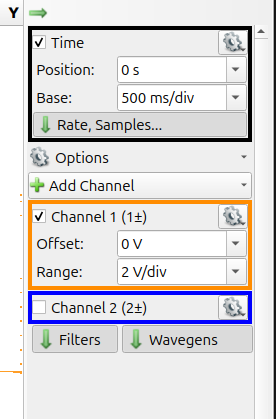
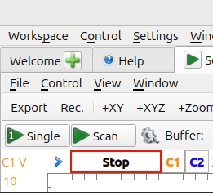
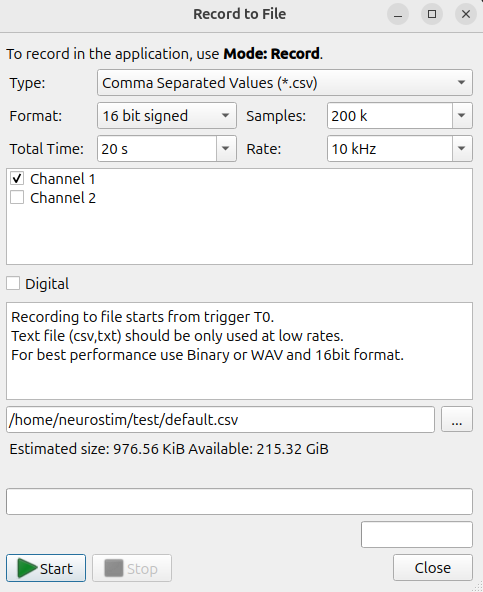